### Import necessary libraries

In [594]:
import SimpleITK as sitk
from ndreg import *
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
from requests import HTTPError
import time
import datetime
import matplotlib
import skimage
from skimage import filters, morphology
import sklearn

In [877]:
%%bash
pip install scikit-learn

In [595]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [596]:
def create_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type, base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel: 
        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource

def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))

def download_ara(rmt, resolution, type='average'):
    if resolution not in [10, 25, 50, 100]:
        print('Please provide a resolution that is among the following: 10, 25, 50, 100')
        return
    REFERENCE_COLLECTION = 'ara_2016'
    REFERENCE_EXPERIMENT = 'sagittal_{}um'.format(resolution)
    REFERENCE_COORDINATE_FRAME = 'ara_2016_{}um'.format(resolution) 
    REFERENCE_CHANNEL = '{}_{}um'.format(type, resolution)

    refImg = download_image(rmt, REFERENCE_COLLECTION, REFERENCE_EXPERIMENT, REFERENCE_CHANNEL, ara_res=resolution)

    return refImg

def download_image(rmt, collection, experiment, channel, res=0, isotropic=True, ara_res=None):
    (exp_resource, coord_resource, channel_resource) = setup_channel_boss(rmt, collection, experiment, channel)
    img = imgDownload_boss(rmt, channel_resource, coord_resource, resolution=res, isotropic=isotropic)
    return img

def downsample_images(spacing, atlas, sampleImg, refThreshold, sampleThreshold):
    downsample_spacing = [spacing,spacing,spacing]

    print("downsampling images to {}...".format(spacing))

    refImg_ds = sitk.Clamp(imgResample(atlas, downsample_spacing), upperBound=refThreshold)

    sampleImg_ds = sitk.Clamp(imgResample(sampleImg, downsample_spacing), upperBound=sampleThreshold)

    print("downsampling done!")

    return (refImg_ds, sampleImg_ds)

In [597]:
def imgBC(img, mask=None, scale=1.0, numBins=64):
    """
    Bias corrects an image using the N4 algorithm
    """
    spacing = np.array(img.GetSpacing())/scale
    img_ds = imgResample(img, spacing=spacing)

    # Calculate bias
    if mask is None:
        mask = sitk.Image(img_ds.GetSize(), sitk.sitkUInt8)+1
        mask.CopyInformation(img_ds)
    else:
        mask = imgResample(mask, spacing=spacing)

    img_ds_bc = sitk.N4BiasFieldCorrection(sitk.Cast(img_ds, sitk.sitkFloat32), mask, numberOfHistogramBins=numBins)
    bias_ds = img_ds_bc - sitk.Cast(img_ds,img_ds_bc.GetPixelID())
    
    # Upsample bias
    bias = imgResample(bias_ds, spacing=img.GetSpacing(), size=img.GetSize())

    # Apply bias to original image and threshold to eliminate negitive values
    upper = np.iinfo(sitkToNpDataTypes[img.GetPixelID()]).max
    img_bc = sitk.Threshold(img + sitk.Cast(bias, img.GetPixelID()),
                            lower=0, upper=upper)
    return img_bc

In [598]:
def imgMetamorphosis(inImg, refImg, alpha=0.02, beta=0.05, scale=1.0, iterations=1000, epsilon=None, sigma=1e-4, useNearest=False,
                     useBias=False, useMI=False, verbose=False, debug=False, inMask=None, refMask=None, outDirPath=""):
    """
    Performs Metamorphic LDDMM between input and reference images
    """
    useTempDir = False
    if outDirPath == "":
        useTempDir = True
        outDirPath = tempfile.mkdtemp() + "/"
    else:
        outDirPath = dirMake(outDirPath)

    inPath = outDirPath + "in.img"
    imgWrite(inImg, inPath)
    refPath = outDirPath + "ref.img"
    imgWrite(refImg, refPath)
    outPath = outDirPath + "out.img"

    fieldPath = outDirPath + "field.vtk"
    invFieldPath = outDirPath + "invField.vtk"

    binPath = ndregDirPath + "metamorphosis "
    steps = 5
    command = binPath + " --in {0} --ref {1} --out {2} --alpha {3} --beta {4} --field {5} --invfield {6} --iterations {7} --scale {8} --steps {9} --verbose ".format(
        inPath, refPath, outPath, alpha, beta, fieldPath, invFieldPath, iterations, scale, steps)
    if(not useBias):
        command += " --mu 0"
    if(useMI):
        # command += " --cost 1 --sigma 1e-5 --epsilon 1e-3"
        command += " --cost 1 --sigma {}".format(sigma)
#         command += " --epsilon {0}".format(epsilon)
        if not(epsilon is None):
            command += " --epsilon {0}".format(epsilon)
        else:
            command += " --epsilon 1e-3"
    else:
#         command += " --sigma {}".format(sigma)
#         command += " --epsilon {0}".format(epsilon)
        if not(epsilon is None):
            command += " --epsilon {0}".format(epsilon)
        else:
            command += " --epsilon 1e-3"
    if(inMask):
        inMaskPath = outDirPath + "inMask.img"
        imgWrite(inMask, inMaskPath)
        command += " --inmask " + inMaskPath

    if(refMask):
        refMaskPath = outDirPath + "refMask.img"
        imgWrite(refMask, refMaskPath)
        command += " --refmask " + refMaskPath

    if debug:
        command = "/usr/bin/time -v " + command
        print(command)

    # os.system(command)
    (returnValue, logText) = run(command, verbose=verbose)

    logPath = outDirPath + "log.txt"
    txtWrite(logText, logPath)

    field = imgRead(fieldPath)
    invField = imgRead(invFieldPath)

    if useTempDir:
        shutil.rmtree(outDirPath)
    return (field, invField)


def imgMetamorphosisComposite(inImg, refImg, alphaList=0.02, betaList=0.05, scaleList=1.0, iterations=1000, epsilonList=None, sigma=1e-4,
                              useNearest=False, useBias=False, useMI=False, inMask=None, refMask=None, verbose=True, debug=False, outDirPath=""):
    """
    Performs Metamorphic LDDMM between input and reference images
    """
    useTempDir = False
    if outDirPath == "":
        useTempDir = True
        outDirPath = tempfile.mkdtemp() + "/"
    else:
        outDirPath = dirMake(outDirPath)

    if isNumber(alphaList):
        alphaList = [float(alphaList)]
    if isNumber(betaList):
        betaList = [float(betaList)]
    if isNumber(scaleList):
        scaleList = [float(scaleList)]

    numSteps = max(len(alphaList), len(betaList), len(scaleList))

    if isNumber(epsilonList):
        epsilonList = [float(epsilonList)] * numSteps
    elif epsilonList is None:
        epsilonList = [None] * numSteps

    if len(alphaList) != numSteps:
        if len(alphaList) != 1:
            raise Exception(
                "Legth of alphaList must be 1 or same length as betaList or scaleList")
        else:
            alphaList *= numSteps

    if len(betaList) != numSteps:
        if len(betaList) != 1:
            raise Exception(
                "Legth of betaList must be 1 or same length as alphaList or scaleList")
        else:
            betaList *= numSteps

    if len(scaleList) != numSteps:
        if len(scaleList) != 1:
            raise Exception(
                "Legth of scaleList must be 1 or same length as alphaList or betaList")
        else:
            scaleList *= numSteps

    origInImg = inImg
    origInMask = inMask
    for step in range(numSteps):
        alpha = alphaList[step]
        beta = betaList[step]
        scale = scaleList[step]
        epsilon = epsilonList[step]
        stepDirPath = outDirPath + "step" + str(step) + "/"
        if(verbose):
            print("\nStep {0}: alpha={1}, beta={2}, scale={3}".format(
                step, alpha, beta, scale))

        (field, invField) = imgMetamorphosis(inImg, refImg,
                                             alpha,
                                             beta,
                                             scale,
                                             iterations,
                                             epsilon,
                                             sigma,
                                             useNearest,
                                             useBias,
                                             useMI,
                                             verbose,
                                             debug,
                                             inMask=inMask,
                                             refMask=refMask,
                                             outDirPath=stepDirPath)

        if step == 0:
            compositeField = field
            compositeInvField = invField
        else:
            compositeField = fieldApplyField(field, compositeField)
            compositeInvField = fieldApplyField(compositeInvField, invField, size=field.GetSize(
            ), spacing=field.GetSpacing())  # force invField to be same size as field

            if outDirPath != "":
                fieldPath = stepDirPath + "field.vtk"
                invFieldPath = stepDirPath + "invField.vtk"
                imgWrite(compositeInvField, invFieldPath)
                imgWrite(compositeField, fieldPath)

        inImg = imgApplyField(origInImg, compositeField, size=refImg.GetSize())
        if(inMask):
            inMask = imgApplyField(origInMask,
                                   compositeField, size=refImg.GetSize(), useNearest=True)
        imgShow(imgApplyField(inImg, compositeField, size=refImg.GetSize(), spacing=refImg.GetSpacing()), vmax=imgPercentile(inImg, 0.99))

    # Write final results
    if outDirPath != "":
        imgWrite(compositeField, outDirPath + "field.vtk")
        imgWrite(compositeInvField, outDirPath + "invField.vtk")
        imgWrite(inImg, outDirPath + "out.img")
        imgWrite(imgChecker(inImg, refImg), outDirPath + "checker.img")

    if useTempDir:
        shutil.rmtree(outDirPath)
    return (compositeField, compositeInvField)

# Step 1: Download atlas and input images

In [599]:
rmt = BossRemote(cfg_file_or_dict='/run/data/.intern/intern.cfg')

In [600]:
# constants
araRes = 50 # um
sampleCollection = 'ailey-dev'
sampleExperiment = 'Thy1eYFP_Control_9_upload20170919'
sampleChannel = 'Ch1'
sampleRes = 3
sampleIso = True

### Downloading ARA Average image

In [601]:
refImg = download_ara(rmt, araRes)
# refImg = imgRead("ara3_average_res2.img")

In [602]:
print(refImg.GetSpacing())
print(refImg.GetSize())

(0.05, 0.05, 0.05)
(264, 160, 228)


In [603]:
refThreshold = imgPercentile(refImg, 0.999)
print(refThreshold)

331.858823529


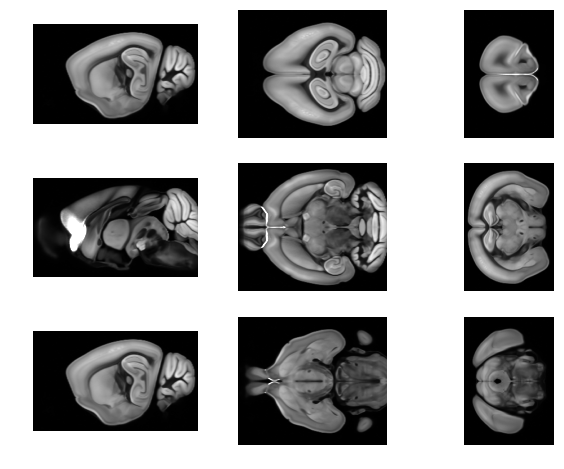

In [604]:
imgShow(refImg, vmax=refThreshold)

### Download atlas annotation image

In [605]:
refAnnoImg = download_ara(rmt, araRes, type='annotation')
# refAnnoImg = imgRead('ara3_annotation_res2.img')

It's usually better to visuaize a set of annotations in color.  Let's display the atlas annotations using a random colormap.  We begin by creating a 1000x3 array of random values. Since we always want the backgrond (label 0) to be dark we make the 0th row is [0,0,0].

In [606]:
randValues = np.random.rand(1000,3)
randValues = np.concatenate(([[0,0,0]],randValues))
randCmap = matplotlib.colors.ListedColormap (randValues)

Now we can display the annotations.

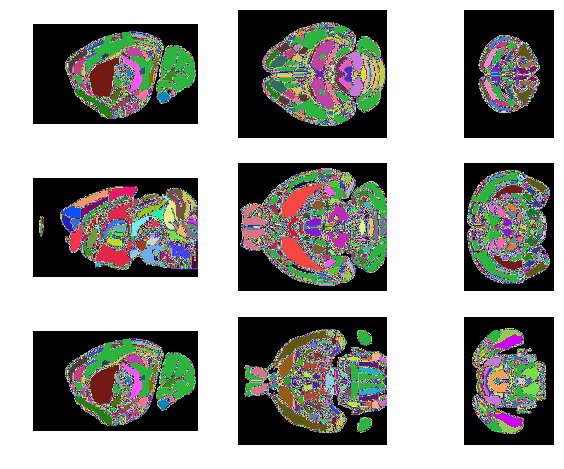

In [607]:
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

### Downloading input image

In [608]:
inImg_orig = download_image(rmt, sampleCollection, sampleExperiment, sampleChannel, res=sampleRes, isotropic=sampleIso)
# inImg_orig = imgRead('ailey-dev_thy1eyfp_control_9_upload20170919_ch1_res3.img')

In [609]:
print(inImg_orig.GetSize())
print(inImg_orig.GetSpacing())

(270, 320, 178)
(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)


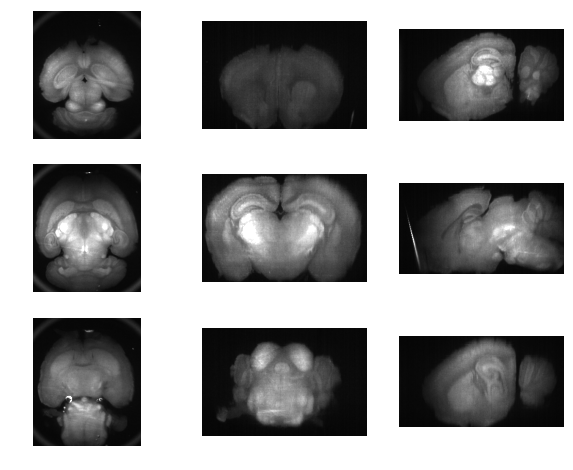

In [610]:
inThreshold = imgPercentile(inImg_orig, 0.999)
imgShow(inImg_orig, vmax=inThreshold)

In [611]:
print(inImg_orig.GetSize())
print(inImg_orig.GetSpacing())

(270, 320, 178)
(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)


# Step 2: Remove streaking artifact

In [837]:
inImg_np = sitk.GetArrayFromImage(inImg_orig)

In [838]:
inImg_np.shape

(178, 320, 270)

In [839]:
# x_size, y_size, z_size = inImg_orig_np.shape
# fx, fy = np.meshgrid(range(y_size), range(z_size))

In [840]:
fft_mag = np.abs(np.fft.fftshift(np.fft.fft2(inImg_np, axes=(-2, -1)), axes=(-2, -1)))**2

In [841]:
fft_mag = np.mean(fft_mag, axis=0)

In [842]:
fft_mag.shape

(320, 270)

In [843]:
fft_mag_log = np.log(fft_mag + 1)
fft_mag_norm = (fft_mag_log - fft_mag_log.min())/(fft_mag_log.max() - fft_mag_log.min())


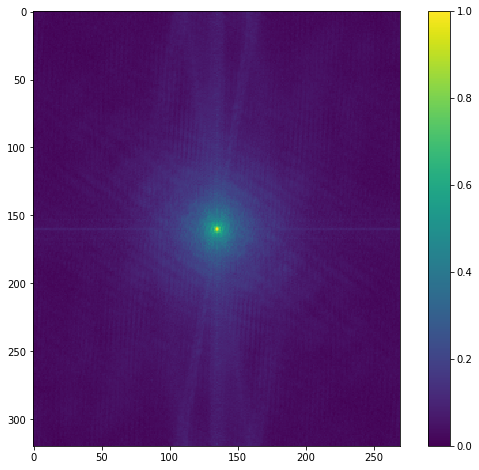

In [844]:
plt.imshow(fft_mag_norm.astype('float32'))
plt.colorbar()
plt.show()

In [845]:
center = [math.ceil((fft_mag_norm.shape[1]+1)/2), math.ceil((fft_mag_norm.shape[0]+1)/2)]
fx, fy = np.meshgrid(np.arange(fft_mag_norm.shape[1]), 
                     np.arange(fft_mag_norm.shape[0]))
fx = fx - center[0]
fy = fy - center[1]
r = np.sqrt(fx**2 + fy**2)
theta = np.arctan2(fy, fx)
# fx = np.fft.fftshift(fx)
# fy = np.fft.fftshift(fy)
# dist_map = np.sqrt(fx**2 + fy**2)

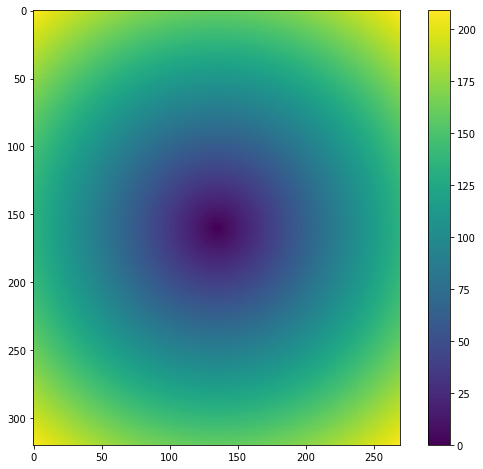

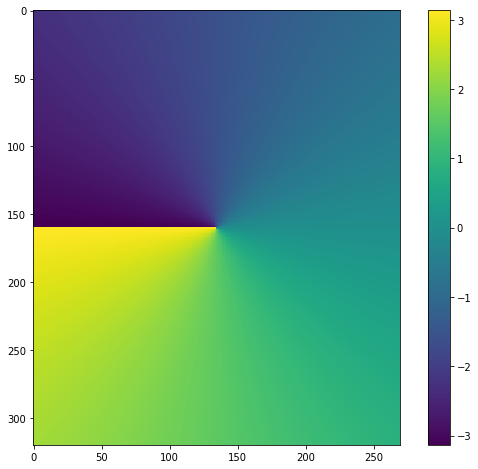

In [846]:
plt.imshow(r)
plt.colorbar()
plt.show()
plt.imshow(theta)
plt.colorbar()
plt.show()

In [847]:
streak1 = -90.0 * (math.pi/180.0) # radians
streak2 = 100.0 * (math.pi/180.0) # radians
streak3 = 80.0 * (math.pi/180.0) # radians
streak4 = 90.0 * (math.pi/180.0) # radians
# streak4_pos = 180.0 * (math.pi/180.0) # radians
# streak4_neg = -180.0 * (math.pi/180.0) # radians 
streak5 = -80.0 * (math.pi/180.0) # radians
streak6 = -100.0 * (math.pi/180.0) # radians
delta = 2 * (math.pi/180.0) # radians
# streak_angles = [streak1, streak2, streak3]
radius = 40 # pixels

In [848]:
streak_filter = np.ones(fft_mag_norm.shape)

In [849]:
small_num = 0.0

In [850]:
streak_filter[(theta < streak1 + delta) & (theta > streak1 - delta)] = small_num
streak_filter[(theta < streak2 + delta) & (theta > streak2 - delta)] = small_num
streak_filter[(theta < streak3 + delta) & (theta > streak3 - delta)] = small_num
streak_filter[(theta < streak4 + delta) & (theta > streak4 - delta)] = small_num
# streak_filter[(theta < streak4_neg + delta) | (theta > streak4_pos - delta)] = small_num
streak_filter[(theta < streak5 + delta) & (theta > streak5 - delta)] = small_num
streak_filter[(theta < streak6 + delta) & (theta > streak6 - delta)] = small_num
streak_filter[ np.where(r < radius) ] = 1.0

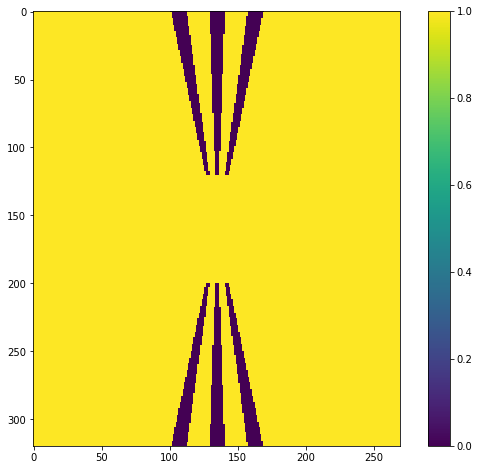

In [851]:
plt.imshow(streak_filter)
plt.colorbar()
plt.show()

In [852]:
streak_filter_blurred = skimage.filters.gaussian(streak_filter, sigma=3)

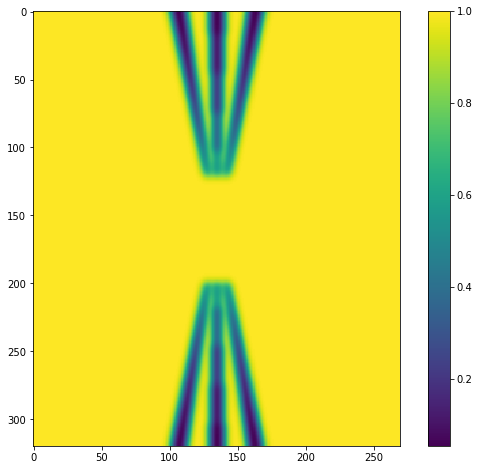

In [853]:
plt.imshow(streak_filter_blurred)
plt.colorbar()
plt.show()

In [854]:
# streak_filter_blurred[int(center[1]),:] = 1.0
# streak_filter_blurred[:,int(center[0])] = 1.0

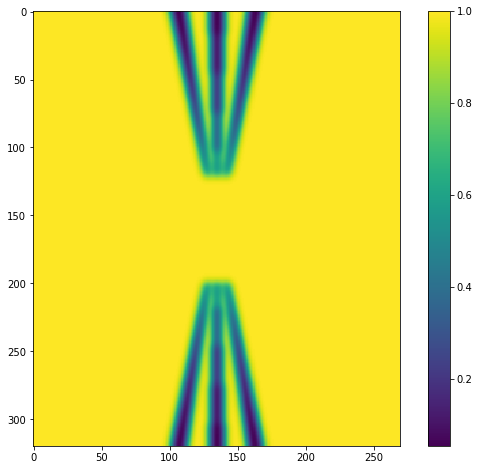

In [855]:
plt.imshow(streak_filter_blurred)
plt.colorbar()
plt.show()

In [856]:
streak_filter_blurred.min()

0.055323792256305467

In [857]:
print(len(np.unique(streak_filter_blurred)))

4179


In [858]:
# streak_filter_blurred = streak_filter_blurred * 0.0 + 1.0

In [859]:
# streak_filter_blurred.shape

In [860]:
# plt.imshow(streak_filter_blurred)
# plt.colorbar()
# plt.show()

In [861]:
# apply filter to image
fft_img = np.fft.fftshift(np.fft.fft2(inImg_np, axes=(-2, -1)), axes=(-2,-1))
print(fft_img.shape)
fft_filtered = np.ones(fft_img.shape, dtype=fft_img.dtype)
for i in range(fft_img.shape[0]):
    fft_filtered[i,:,:] = np.multiply(fft_img[i,:,:], streak_filter_blurred)
print(fft_filtered.shape)

(178, 320, 270)
(178, 320, 270)


In [862]:
fft_img.dtype

dtype('complex128')

In [863]:
fft_filtered.dtype

dtype('complex128')

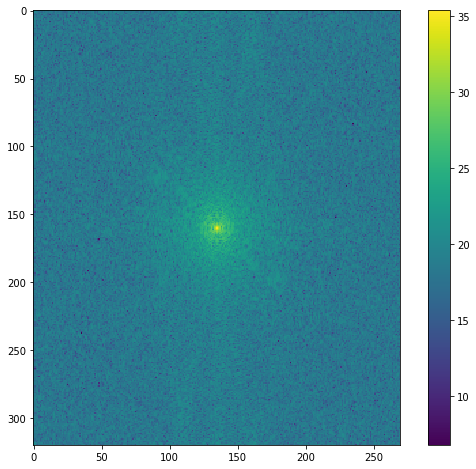

In [864]:
plt.imshow(2*np.log(np.abs(fft_img[80,:,:])))
plt.colorbar()
plt.show()

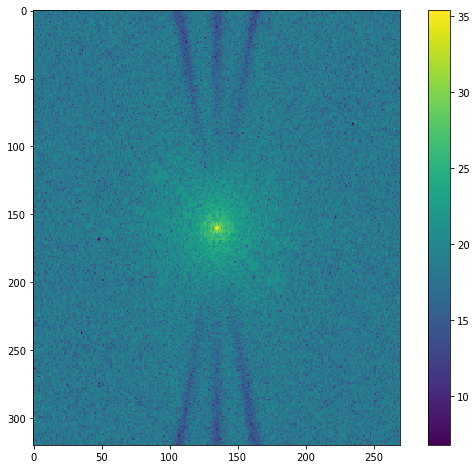

In [865]:
plt.imshow(2*np.log(np.abs(fft_filtered[80,:,:])))
plt.colorbar()
plt.show()

In [866]:
filtered_fft = np.fft.ifftshift(fft_filtered, axes=(-2,-1))
# filtered_fft[0,:,:] = np.fft.ifftshift(fft_img, axes=(-2,-1))[0,:,:]
# filtered_fft[:,0,:] = np.fft.ifftshift(fft_img, axes=(-2,-1))[:,0,:]
# filtered_fft[:,:,0] = np.fft.ifftshift(fft_img, axes=(-2,-1))[:,:,0]
inv_fft = np.fft.ifft2(filtered_fft, axes=(-2,-1))
# inv_fft = np.fft.fftshift(np.fft.ifft2(fft_filtered, axes=(-2,-1)), axes=(-2,-1))

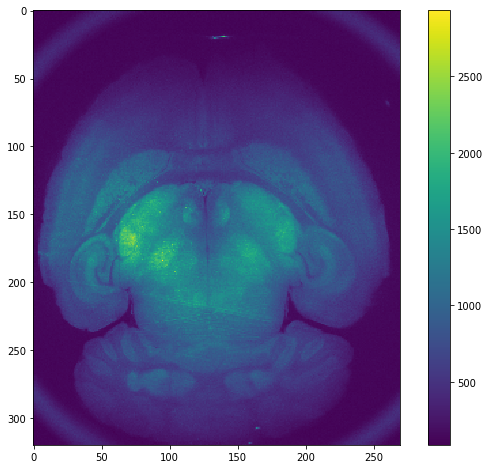

In [867]:
plt.imshow(inImg_np[80,:,:].astype('float32'))
plt.colorbar()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


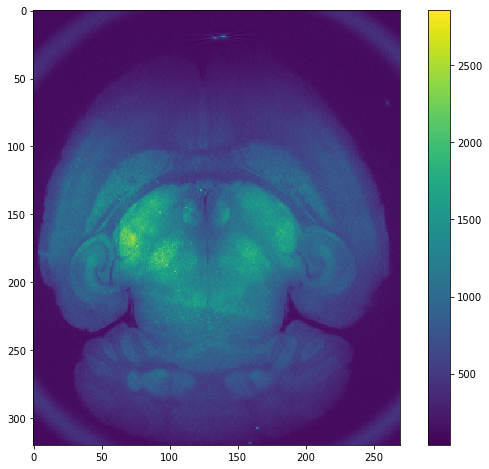

In [868]:
plt.imshow(inv_fft[80,:,:].astype('float32'))
plt.colorbar()
plt.show()

In [869]:
inv_fft[80,:,:]

array([[ 119.09715180-0.02083542j,  117.73690864-0.02157881j,
         122.67003141-0.01012979j, ...,  120.47171926+0.01894826j,
         117.62555085+0.00753662j,  125.46958025-0.0087742j ],
       [ 112.57490962+0.02066326j,  136.02551375+0.02160666j,
         116.67038572+0.01033541j, ...,  124.05067329-0.01886865j,
         105.69825583-0.00767777j,  114.47187099+0.00852556j],
       [ 113.83819564-0.02043778j,  121.17608945-0.02157471j,
         107.04988189-0.01050832j, ...,  103.56242365+0.01873128j,
         102.77619386+0.00779001j,  110.98323272-0.00826005j],
       ..., 
       [ 117.65797360+0.02101898j,  111.88491363+0.02112897j,
         123.49407516+0.00931881j, ...,  117.78119661-0.01883579j,
         122.38665597-0.00694418j,  127.77195134+0.00940734j],
       [  98.36999735-0.02101444j,  109.99453730-0.02134047j,
         112.44442817-0.00962105j, ...,  132.43598439+0.01893205j,
         118.94390327+0.00716916j,  115.45708907-0.00921631j],
       [ 112.41419285+0.020

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


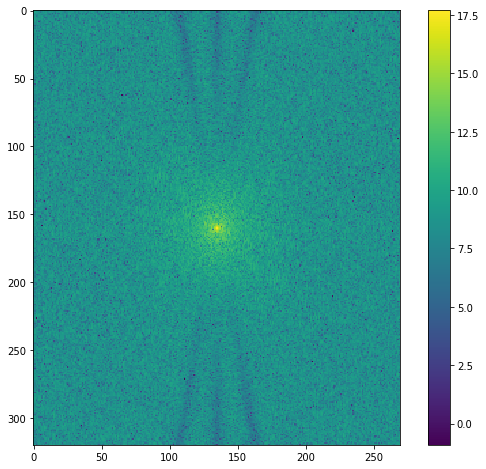

In [870]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.ifft2(np.fft.ifftshift(fft_filtered[80,:,:], axes=(-2, -1)))).astype('float32')))))
plt.colorbar()
plt.show()

# Step 4: Get rid of circle

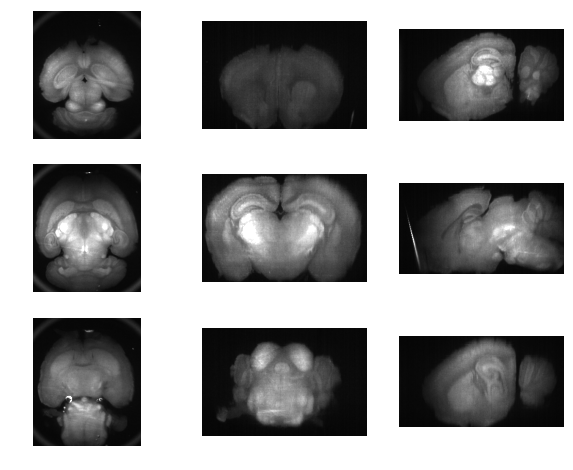

In [954]:
imgShow(inImg_orig, vmax=inThreshold)

In [956]:
# inImg_bc_masked = sitk.Mask(inImg_bc, inMask_sitk)
inImg_orig_np = sitk.GetArrayFromImage(inImg_orig)

In [958]:
# print(inImg_bc_masked.GetSize())
# print(inImg_bc_masked.GetSpacing())

In [960]:
# imgShow(inImg_bc_masked, vmax=inThreshold)

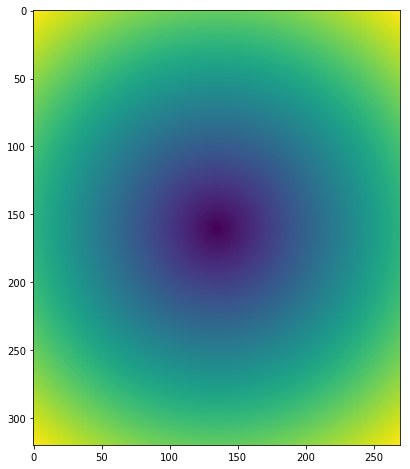

In [1026]:

radius = 170 # px
origin_shift = [0, 0]
center = [inImg_orig_np.shape[-1]/2 + origin_shift[0], inImg_orig_np.shape[-2]/2 + origin_shift[1]]
x, y, z = inImg_orig_np.shape
mask = np.zeros((y,z))
for i in range(y):
    for j in range(z):
        mask[i,j] = math.sqrt((i-center[1])**2 + (j-center[0])**2)
plt.imshow(mask)
plt.show()

In [1027]:
mask = (mask < radius).astype('uint64')

In [1028]:
# new_mask = np.repeat(mask[:,:,None], inImg_orig_np.shape[0], axis=2)
new_mask = np.repeat(mask[None,:,:], inImg_orig_np.shape[0], axis=0)

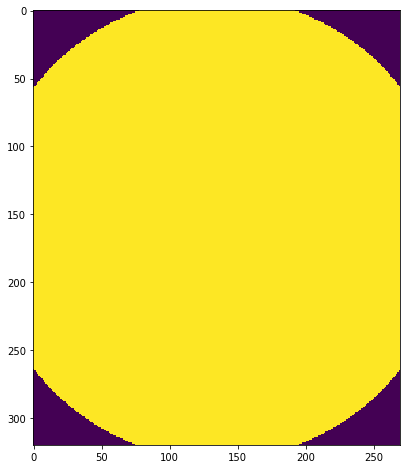

In [1030]:
plt.imshow(new_mask[80,:,:])
plt.show()

In [1031]:
inImg_orig_masked = np.multiply(inImg_orig_np, new_mask)

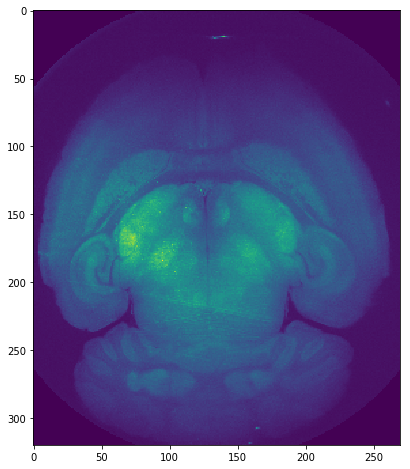

In [1037]:
plt.imshow(inImg_orig_masked[80,:,:])
plt.show()

In [1038]:
inImg_orig_masked = sitk.GetImageFromArray(inImg_orig_masked)
inImg_orig_masked.SetSpacing(inImg_orig.GetSpacing())

In [1033]:
print(inImg_orig.GetSize())
print(inImg_orig.GetSpacing())
print(inImg_orig.GetPixelIDTypeAsString())

(270, 320, 178)
(0.041280000000000004, 0.041280000000000004, 0.041280000000000004)
16-bit unsigned integer


In [1034]:
print(inMask_sitk.GetSize())
print(inMask_sitk.GetSpacing())
print(inMask_sitk.GetPixelIDTypeAsString())

NameError: name 'inMask_sitk' is not defined

# Step 3: Create a mask

In [1040]:
from sklearn import mixture

In [1041]:
# inImg_orig_np = sitk.GetArrayFromImage(inImg_orig)
inImg_orig_np = sitk.GetArrayFromImage(inImg_orig_masked)

In [1056]:
inImg_orig_np.ravel().reshape(-1, 1).shape

(15379200, 1)

In [1049]:
gmix = mixture.gaussian_mixture.GaussianMixture(n_components=3, covariance_type='full', init_params='kmeans', verbose=1)
gmix.fit(inImg_orig_np.ravel().reshape(-1, 1))

Initialization 0
  Iteration 0
Initialization converged: True
Initialization 1
  Iteration 0
Initialization converged: True
Initialization 2
  Iteration 0
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=3, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [1050]:
gmix.means_

array([[  547.40002334],
       [ 1010.5491436 ],
       [  117.39781948]])

In [1051]:
gmix.covariances_

array([[[  53243.97187751]],

       [[ 119693.25134205]],

       [[   3116.00153885]]])

In [1087]:
gmix.predict_proba(246.5)

array([[ 0.47192731,  0.02760774,  0.50046495]])

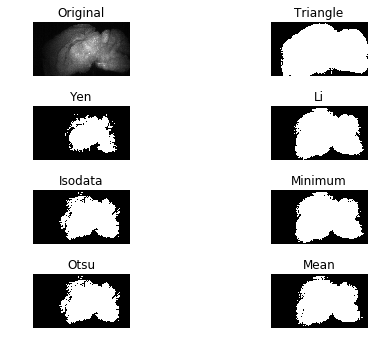

In [924]:

inMask = np.zeros(inImg_orig_np.shape)
fig, ax = filters.try_all_threshold(inImg_orig_np[:,:,100], verbose=False)
_ = plt.show()
for i in range(inImg_orig_np.shape[-1]):
    thresh = filters.threshold_triangle(inImg_orig_np[:,:,i])
    inMask[:,:,i] = np.where( inImg_orig_np[:,:,i] >= thresh, 1, 0) 
    

In [1100]:
test_mask = (inImg_orig_np > 190)

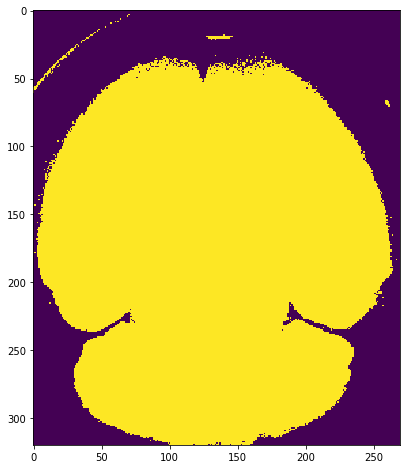

In [1101]:
_ = plt.imshow(test_mask[80,:,:])
plt.show()

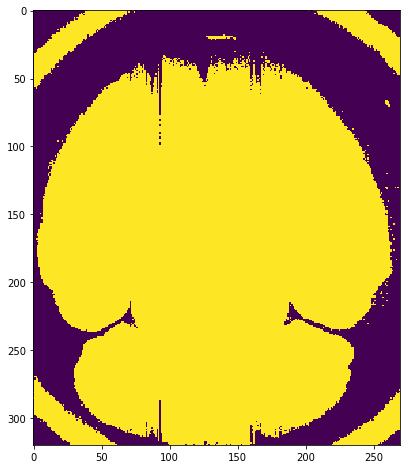

In [872]:
_ = plt.imshow(inMask[80,:,:])
plt.show()

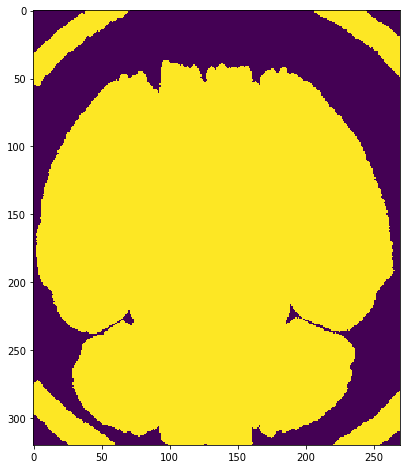

In [873]:
# include some morphological erosion/dilation operations
eroded_im = morphology.opening(inMask, selem=morphology.ball(2))
eroded_im = morphology.binary_dilation(eroded_im)
plt.imshow(eroded_im[80,:,:])
# plt.imshow(morphology.binary_erosion(morphology.binary_dilation(inMask[80,:,:]), ))
plt.show()
# sitk.BinaryDilateImageFilter().Execute(inMask)

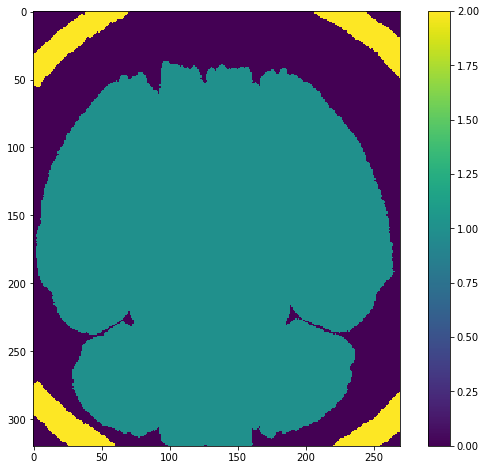

In [874]:
connected_components = skimage.measure.label(eroded_im, background=0)
plt.imshow(connected_components[80,:,:], vmax=2)
plt.colorbar()
plt.show()

In [875]:
inMask = np.where(connected_components == 1.0, 1.0, 0.0)

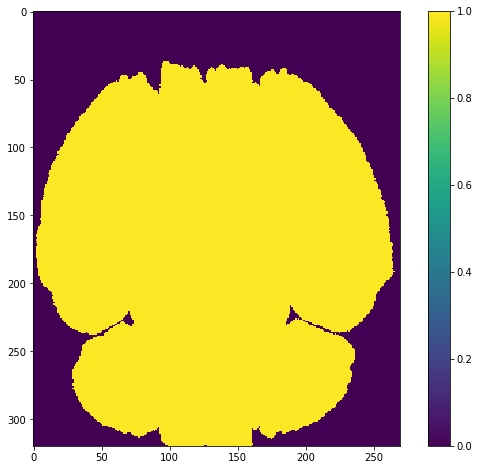

In [876]:
plt.imshow(inMask[80,:,:])
plt.colorbar()
plt.show()

In [ ]:
inMask_sitk = sitk.Cast(sitk.GetImageFromArray(inMask), sitk.sitkUInt8)
inMask_sitk.SetSpacing(inImg_orig.GetSpacing())

## Bias correcting input image
This intensity values of this image appear to be biased.  As a result the anterior end of the brain is dimmer than the rest of the end.  Thus we use the N4 bias correction algorithm to correct this.  To make this run quickly we use a scale factor 0.2.

In [833]:
imgShow(inMask_sitk)

NameError: name 'inMask_sitk' is not defined

In [834]:
inImg_bc = imgBC(inImg_orig, mask=inMask_sitk, scale=0.2)
inImg_bc_casted = sitk.Cast(inImg_bc, sitk.sitkUInt16)

NameError: name 'inMask_sitk' is not defined

In [835]:
inThreshold_bc = imgPercentile(inImg_bc, 0.9995)
print(inThreshold_bc)

NameError: name 'inImg_bc' is not defined

In [ ]:
imgShow(inImg_orig, vmax=inThreshold)
imgShow(inImg_bc, vmax=inThreshold_bc)
# imgShow(inImg_bc)

# Step 6: Adaptive Histogram Equalization (CLAHE)

In [ ]:
inImg_bc_np = sitk.GetArrayFromImage(inImg_bc_masked)
print(inImg_bc_np.shape)

In [ ]:
plt.imshow(inImg_bc_np[80,:,:], cmap='gray', vmax=inThreshold)
plt.colorbar()
plt.show()
# plt.imshow(inImg_orig_np[80,:,:])
# plt.colorbar()
# plt.show()

In [ ]:
# inImg_bc_clahe = np.zeros(inImg_bc_np.shape)
# for i in range(inImg_bc_np.shape[-1]):
#     inImg_bc_clahe[:,:,i] = skimage.exposure.equalize_adapthist(inImg_bc_np[:,:,i], clip_limit=0.1, kernel_radius=10)
# #     plt.imshow(inImg_bc_clahe[:,:,i], cmap='gray', vmax=1)
# #     plt.colorbar()
# #     plt.show()
# # #     time.sleep(0.5)
# #     plt.close()

In [ ]:
# inImg_bc_clahe = sitk.GetImageFromArray(inImg_bc_clahe)
# inImg_bc_clahe.SetSpacing(inImg_bc_masked.GetSpacing())

In [ ]:
# inThreshold_clahe = imgPercentile(inImg_bc_clahe, 0.99)

In [ ]:
# imgShow(inImg_bc_clahe, vmax=inThreshold_clahe)

In [ ]:
# print(inThreshold)

In [ ]:
# refImg_np = sitk.GetArrayFromImage(refImg)
# refImg_clahe = np.zeros(refImg_np.shape)
# for i in range(refImg_np.shape[0]):
#     refImg_clahe[i,:,:] = skimage.exposure.equalize_adapthist(refImg_np[i,:,:], clip_limit=0.1, kernel_radius=10)
# #     plt.imshow(refImg_clahe[i,:,:], cmap='gray', vmax=3)
# #     plt.colorbar()
# #     plt.show()
# # #     time.sleep(0.5)
# #     plt.close()

In [ ]:
# print(refImg_clahe.shape)

In [ ]:
# refImg_clahe = sitk.GetImageFromArray(refImg_clahe)
# refImg_clahe.SetSpacing(refImg.GetSpacing())

In [ ]:
# refThreshold_clahe = imgPercentile(refImg_clahe, 0.99)

In [ ]:
# imgShow(refImg_clahe, vmax=refThreshold_clahe)

# Reorienting input image
You may have noticed that the input brain is not oriented in the same way as the atlas.  Let's look at the atlas.

In [ ]:
imgShow(refImg, vmax=refThreshold)
# imgShow(refImg_clahe, vmax=refThreshold_clahe)

In [ ]:
imgShow(inImg_orig, vmax=inThreshold)
# imgShow(inImg_bc_clahe, vmax=inThreshold_clahe)

In [ ]:
inOrient = "LAS"
refOrient = "ASR"
inImgReoriented = imgReorient(inImg_bc_masked, inOrient, refOrient)
imgShow(inImgReoriented, vmax=inThreshold)
# inImgReoriented = imgReorient(inImg_bc_clahe, inOrient, refOrient)
# imgShow(inImgReoriented, vmax=inThreshold_clahe)

# Step 2: Downsample images
Now we downsample the input and reference images to a more manageable size

In [ ]:
DOWNSAMPLE_SPACING = 0.100 # millimeters
spacing = [DOWNSAMPLE_SPACING,DOWNSAMPLE_SPACING,DOWNSAMPLE_SPACING]

In [ ]:
refImg_ds = sitk.Clamp(imgResample(refImg, spacing), upperBound=refThreshold)
# 00imgShow(refImg_ds)


In [ ]:
inImg_ds = sitk.Clamp(imgResample(inImgReoriented, spacing), upperBound=inThreshold)
imgShow(inImg_ds)

# Normalize both images to be [0,1]

In [ ]:
# max_val = inThreshold
# min_val = 0
# inImg_ds = (inImg_ds - min_val)/(max_val - min_val)

In [ ]:
# max_val = refThreshold
# min_val = 0
# refImg_ds = (refImg_ds - min_val)/(max_val - min_val)

In [ ]:
imgShow(inImg_ds)
imgShow(refImg_ds)

# Pad Images

In [ ]:
inImg_ds_padded = np.pad(sitk.GetArrayFromImage(inImg_ds), [(20,20),(20,20),(20,20)], 'constant')
inImg_ds_padded = sitk.GetImageFromArray(inImg_ds_padded)
inImg_ds_padded.SetSpacing(inImg_ds.GetSpacing())
imgShow(inImg_ds_padded)

In [ ]:
refImg_ds_padded = np.pad(sitk.GetArrayFromImage(refImg_ds), [(20,20),(20,20),(20,20)], 'constant')
refImg_ds_padded = sitk.GetImageFromArray(refImg_ds_padded)
refImg_ds_padded.SetSpacing(refImg_ds.GetSpacing())
imgShow(refImg_ds_padded)

# Affine Registration
Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the input and reference images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [ ]:
affine = imgAffineComposite(inImg_ds_padded,  refImg_ds_padded, iterations=300,  useMI=False, verbose=True, epsilon=0.01, methodList=[3])
# affine = imgAffineComposite(imgHM(refImg_ds, inImg_ds), inImg_ds, iterations=1000,  useMI=False, verbose=True, epsilon=0.05, methodList=[0,3])
# affine = imgAffineComposite(inImg_ds_padded, refImg_ds_padded, iterations=1000,  useMI=False, verbose=True, epsilon=0.001, methodList=[3])
# affine = imgAffineComposite(inImg_ds,  refImg_ds, iterations=200,  useMI=False, verbose=True, epsilon=0.05, methodList=[0,3])

Now we apply the affine transform to the input image and mask

In [ ]:
# print(affine)
# refImg_affine = imgApplyAffine(refImg, affine, size=inImgReoriented.GetSize(), spacing=inImgReoriented.GetSpacing())
# imgShow(refImg_affine, vmax=refThreshold)

In [ ]:
# refImg_ds2 = sitk.Clamp(imgResample(refImg_affine, spacing=spacing, size=inImg_ds.GetSize()),upperBound=refThreshold)
# imgShow(imgChecker(refImg_ds2, inImg_ds))

In [ ]:
print(affine)
inImg_affine = imgApplyAffine(inImgReoriented, affine, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(inImg_affine, vmax=inThreshold)

We can evaluate the affine registration by generating a checkerboard of the reference and input images.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

In [ ]:
inImg_ds2 = sitk.Clamp(imgResample(inImg_affine, spacing=spacing, size=refImg_ds.GetSize()),upperBound=inThreshold)
imgShow(imgChecker(inImg_ds2, refImg_ds))

# LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input brain and reference image have very differnt intensity profiles.

In [ ]:
(field, invField) = imgMetamorphosisComposite(inImg_ds2, refImg_ds, alphaList=[0.1, 0.05, 0.02, 0.01],
                                              scaleList = 0.0625, epsilonList=5e-4, sigma=1e-4, 
                                              useMI=False, iterations=400, verbose=True)
# (field, invField) = imgMetamorphosisComposite(imgHM(inImg_ds2, refImg_ds), refImg_ds, alphaList=[0.1, 0.05, 0.02, 0.01],# 0.05, 0.02],
#                                               scaleList = 0.25, useMI=False, iterations=300, verbose=True)

We now create a composite of the affine and displacement fields

In [ ]:
affineField = affineToField(affine, field.GetSize(), field.GetSpacing())
fieldComposite = fieldApplyField(field, affineField)

invAffineField = affineToField(affineInverse(affine), invField.GetSize(), invField.GetSpacing())
invFieldComposite = fieldApplyField(invAffineField, invField)

Now we apply the displacement field

In [ ]:
inImg_lddmm = imgApplyField(inImgReoriented, fieldComposite, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(inImg_lddmm, vmax=inThreshold_clahe)
imgShow(refImg)
###imgWrite(imgResample(inImg_lddmm, spacing=[0.04]*3, size=[285,200,330]),"/cis/project/clarity/data/ailey/s3617_to_ara3_res2_refined_refined.img") ###

### Evaluation LDDMM registration
Now we evaluate the deformable registration using a checkerboard image

In [ ]:
# imgShow(imgChecker(inImg_lddmm, refImg), vmax=refThreshold)
# imgShow(imgChecker(inImg_lddmm, refImg), vmax=inThreshold_clahe)

# Step 3: Perform Registration

In [ ]:
fixedImage = inImg_ds
movingImage = refImg_ds


In [ ]:
# set parameters
rigidParameterMap = sitk.GetDefaultParameterMap('rigid')
affineParameterMap = sitk.GetDefaultParameterMap('affine')
rigidParameterMap['Metric'] = ['AdvancedMeanSquares']
affineParameterMap['Metric'] = ['AdvancedMeanSquares']
affineParameterMap['MaximumNumberOfIterations'] = ['100000.00']
rigidParameterMap['MaximumNumberOfIterations'] = ['100000.00']
# p['Transform'] = ['TranslationTransform']

In [ ]:
sitk.PrintParameterMap(rigidParameterMap)

In [ ]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(affineParameterMap)
elastixImageFilter.Execute()

In [ ]:
resultImage = elastixImageFilter.GetResultImage()
transformParameterMap = elastixImageFilter.GetTransformParameterMap()

In [ ]:
resultImage.GetSize()

In [ ]:
imgShow(imgChecker(inImg_ds, resultImage))

In [ ]:
imgShow(resultImage)